# Training a model

### We training a model for customer segments

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import joblib  


In [2]:
# ---------------------------------------------
# 1️⃣ Load your Superstore Orders sheet
# ---------------------------------------------
df = pd.read_excel('/datasets/Sample_Superstore.xlsx', sheet_name='Orders')
df.head()


,A`,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,4962,CA-2016-156587,2016-03-07,2016-03-08,First Class,AB-10015,Aaron Bergman,Consumer,United States,Seattle,...,98103.0,West,FUR-CH-10004477,Furniture,Chairs,"Global Push Button Manager's Chair, Indigo",48.712,1,0.2,5.4801
1,4963,CA-2016-156587,2016-03-07,2016-03-08,First Class,AB-10015,Aaron Bergman,Consumer,United States,Seattle,...,98103.0,West,OFF-AR-10001427,Office Supplies,Art,Newell 330,17.940,3,0.0,4.6644
2,4964,CA-2016-156587,2016-03-07,2016-03-08,First Class,AB-10015,Aaron Bergman,Consumer,United States,Seattle,...,98103.0,West,OFF-ST-10002344,Office Supplies,Storage,"Carina 42""Hx23 3/4""W Media Storage Unit",242.940,3,0.0,4.8588
3,8223,CA-2016-152905,2016-02-18,2016-02-24,Standard Class,AB-10015,Aaron Bergman,Consumer,United States,Arlington,...,76017.0,Central,OFF-ST-10000321,Office Supplies,Storage,Akro Stacking Bins,12.624,2,0.2,-2.5248
4,8802,CA-2018-140935,2018-11-10,2018-11-12,First Class,AB-10015,Aaron Bergman,Consumer,United States,Oklahoma City,...,73120.0,Central,TEC-PH-10000562,Technology,Phones,Samsung Convoy 3,221.980,2,0.0,62.1544


In [3]:
# 2️⃣ Aggregate to Customer Level
# ---------------------------------------------
customer_df = df.groupby(['Customer ID', 'Customer Name']).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'Discount': 'mean',
    'Order ID': 'nunique',
    'Category': 'nunique'
}).reset_index()

In [4]:
customer_df = customer_df.rename(columns={
    'Sales': 'Total_Sales',
    'Profit': 'Total_Profit',
    'Quantity': 'Total_Quantity',
    'Discount': 'Avg_Discount',
    'Order ID': 'Num_Orders',
    'Category': 'Num_Categories'
})

In [ ]:
print("✅ Aggregated Customer Data:")
print(customer_df.head())

✅ Aggregated Customer Data:
  Customer ID  Customer Name  Total_Sales  Total_Profit  Total_Quantity  \
0    AA-10315     Alex Avila     5563.560     -362.8825              30   
1    AA-10375   Allen Armold     1056.390      277.3824              41   
2    AA-10480   Andrew Allen     1790.512      435.8274              36   
3    AA-10645  Anna Andreadi     5086.935      857.8033              64   
4    AB-10015  Aaron Bergman      886.156      129.3465              13   

   Avg_Discount  Num_Orders  Num_Categories  
0      0.090909           5               3  
1      0.080000           9               3  
2      0.016667           4               3  
3      0.063889           6               3  
4      0.066667           3               3  


In [6]:
# Save the customer-level dataset for your Flask upload test
customer_df.to_csv('./datasets/customer_segments.csv', index=False)

In [ ]:
# 3️⃣ Select features & scale
# ---------------------------------------------
features = ['Total_Sales', 'Total_Profit', 'Total_Quantity',
            'Avg_Discount', 'Num_Orders', 'Num_Categories']

In [9]:
X = customer_df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# 4️⃣ Hyperparameter Tuning (Elbow + Silhouette)
# ---------------------------------------------
inertia = []
silhouette = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, clusters)
    silhouette.append(sil_score)
    print(f"K={k} | Inertia: {kmeans.inertia_:.2f} | Silhouette: {sil_score:.3f}")

K=2 | Inertia: 3456.94 | Silhouette: 0.262
K=3 | Inertia: 2807.06 | Silhouette: 0.266
K=4 | Inertia: 2398.57 | Silhouette: 0.266
K=5 | Inertia: 2195.47 | Silhouette: 0.228
K=6 | Inertia: 1959.37 | Silhouette: 0.233
K=7 | Inertia: 1808.39 | Silhouette: 0.241
K=8 | Inertia: 1678.80 | Silhouette: 0.226
K=9 | Inertia: 1490.62 | Silhouette: 0.250
K=10 | Inertia: 1398.50 | Silhouette: 0.225


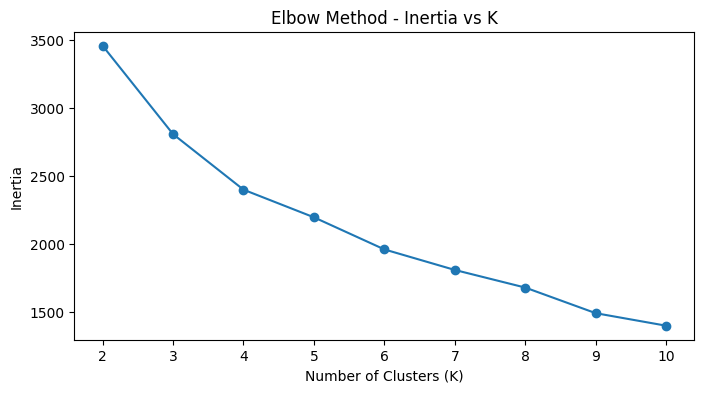

In [11]:
# Plot Elbow
plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method - Inertia vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.show()

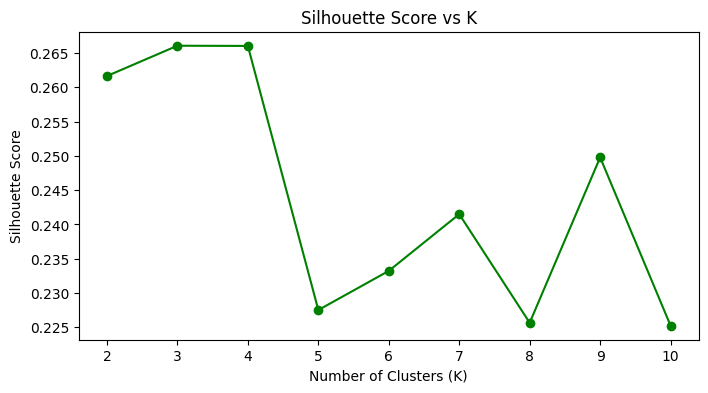

In [12]:
# Plot Silhouette
plt.figure(figsize=(8,4))
plt.plot(K_range, silhouette, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.show()

In [15]:
# 5️⃣ Train final K-Means with chosen K
# ---------------------------------------------
# ⚡ Pick the best K you see from plots! Example: K=4
final_k = 4  # <-- Replace with your chosen K
kmeans = KMeans(n_clusters=final_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

customer_df['Cluster'] = clusters

In [16]:
# Save final results
customer_df.to_csv('customer_segments_with_clusters.csv', index=False)

In [19]:
# ---------------------------------------------
# 6️⃣ Save Model & Scaler for Flask
# ---------------------------------------------
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\n✅ Final Clustering done!")
print("- Saved: kmeans_model.pkl, scaler.pkl, customer_segments_with_clusters.csv")


✅ Final Clustering done!
- Saved: kmeans_model.pkl, scaler.pkl, customer_segments_with_clusters.csv
